In [1]:
%cd ~/desktop/RNA/casp16
casp_id = "R1255"
pdb_dir=f"./datasets/casp16/{casp_id}/pdb"

/Users/sumishunsuke/Desktop/RNA/casp16


/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# energy calc 

In [2]:
!ls {pdb_dir}/*pdb | wc -l

!python ./scripts/eval_scores.py --pdb_dir {pdb_dir} --out_dir {pdb_dir}

    1000
['S_000668.pdb', 'S_000654.pdb', 'S_000132.pdb', 'S_000126.pdb']
Traceback (most recent call last):
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 83, in <module>
    main()
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 66, in main
    res_rnabriq = RNA_BRiQ.RNA_BRiQ_eval_batch(args.pdb_dir, args.out_dir, args.cpu)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./src/score/RNA_BRiQ.py", line 67, in RNA_BRiQ_eval_batch
    energy = float(lines[-1].strip().replace("Energy: ", ""))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'check ribose:'


In [3]:
all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f1
all_pdb_ids[:3]

['S_000001', 'S_000002', 'S_000003']

In [4]:
# re-proc

all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f1
print(len(all_pdb_ids))

energies = {}
unprocessed = []
for pdb_id in all_pdb_ids:
    f = f"{pdb_dir}/{pdb_id}.briq.out"
    try:
        with open(f) as fh: lines = fh.readlines()
        energies[f] = float(lines[-1].strip().replace("Energy: ", ""))
    except:
        unprocessed.append(pdb_id)

print(len(energies), len(unprocessed))

1000
995 5


In [5]:
if len(unprocessed) != 0:
    import sys
    sys.path.append("./")
    from src.score import RNA_BRiQ
    from multiprocessing import Pool

    with Pool(3) as pool:
        results = pool.map(
            RNA_BRiQ.process_pdb_file_eval,
            [f"{pdb_dir}/{pdb_id}.pdb" for pdb_id in unprocessed]
            )

# energy書き出し

In [6]:
out_files = !ls {pdb_dir}/*briq.out

pdb_energy = {}
for out in out_files:
    with open(out) as fh: 
        lines = fh.readlines()
    energies = float(lines[-1].strip().replace("Energy: ", ""))
    basename = out.split("/")[-1].replace(".briq.out", "")
    pdb_energy[basename] = energies


pdb_energy["S_000001"]

import pandas as pd
df_briq = pd.DataFrame(pdb_energy.items(), columns=["pdb", "BRiQscore"])
df_briq.head(3)

,pdb,BRiQscore
0,S_000001,-198.758
1,S_000002,-113.573
2,S_000003,-161.397


In [7]:
import pandas as pd 
df_farfar = pd.read_csv(f"{pdb_dir}/{casp_id}_FARFAR2_scores.csv")
df_farfar = df_farfar[["score", "description"]]
df_farfar.columns = ["FARFARscore", "pdb"]
df_farfar.head(3)

df = pd.merge(df_briq, df_farfar, on="pdb")
df.to_csv(f"{pdb_dir}/{casp_id}_scores.csv", index=False)

# 可視化

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(403, 3)


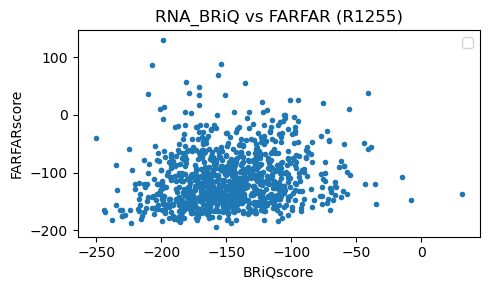

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores.csv")


n_take = 250
df_briq_top = df_scores.sort_values("BRiQscore", ascending=True).head(n_take)
df_farfar_top = df_scores.sort_values("FARFARscore", ascending=True).head(n_take)
df_both_top = pd.concat([df_briq_top, df_farfar_top]).drop_duplicates()


plt.figure(figsize=(5,3))
plt.scatter(df_scores["BRiQscore"], df_scores["FARFARscore"], marker=".")
# plt.scatter(df_both_top["BRiQscore"], df_both_top["FARFARscore"], marker=".", color="orange", label=f"Top {n_take}")
plt.legend()
plt.xlabel("BRiQscore")
plt.ylabel("FARFARscore")
plt.title(f"RNA_BRiQ vs FARFAR ({casp_id})")

print(df_both_top.shape)
plt.tight_layout()
plt.savefig(f"{pdb_dir}/{casp_id}_scores.pdf")

# 距離行列計算

In [3]:
%cd ~/desktop/RNA/casp16

from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/Users/sumishunsuke/Desktop/RNA/casp16


/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
!time python scripts/calc_rmsd.py --pdb_dir {pdb_dir} --cpu 7

['S_000001.pdb', 'S_000002.pdb', 'S_000003.pdb', 'S_000004.pdb', 'S_000005.pdb']
Number of pdb files: 1000
Calculating RMSD matrix 1000x1000 using 7 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 20th pdb file
Calculating RMSD for 40th pdb file
Calculating RMSD for 60th pdb file
Calculating RMSD for 80th pdb file
Calculating RMSD for 120th pdb file
Calculating RMSD for 100th pdb file
Calculating RMSD for 10th pdb file
Calculating RMSD for 30th pdb file
Calculating RMSD for 50th pdb file
Calculating RMSD for 70th pdb file
Calculating RMSD for 130th pdb file
Calculating RMSD for 90th pdb file
Calculating RMSD for 110th pdb file
Calculating RMSD for 200th pdb file
Calculating RMSD for 270th pdb file
Calculating RMSD for 180th pdb file
Calculating RMSD for 160th pdb file
Calculating RMSD for 250th pdb file
Calculating RMSD for 140th pdb file
Calculating RMSD for 230th pdb file
Calculating RMSD for 280th pdb file
Calculating RMSD for 210th pdb file
Calculating RMSD for 190th pd

/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


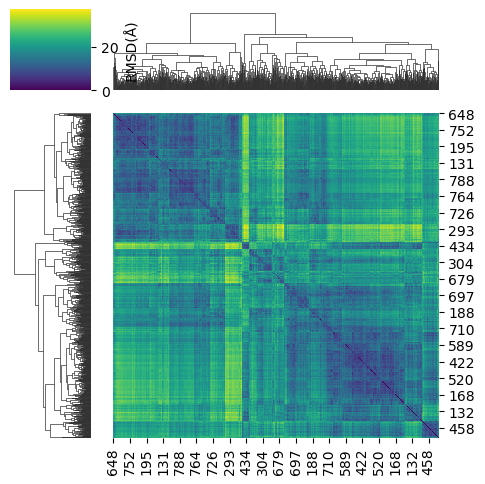

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

rmsd = np.load(f"{pdb_dir}/rmsd_matrix_sorted_id.npy")
g = sns.clustermap(rmsd, cmap="viridis", figsize=(5,5), cbar_kws={'label': 'RMSD(Å)', 'aspect': 20})
plt.tight_layout()
plt.savefig(f"{pdb_dir}/rmsd_clustermap.png", dpi = 300)

In [11]:
all_pdb_ids = !ls {pdb_dir}/*pdb | xargs -n 1 basename | cut -d. -f1
print(len(all_pdb_ids))
print(all_pdb_ids[:3])

1000
['S_000001', 'S_000002', 'S_000003']


In [12]:
df_rmsd = pd.DataFrame(rmsd, columns=all_pdb_ids, index=all_pdb_ids)
df_rmsd.to_csv(f"{pdb_dir}/rmsd_matrix_sorted_id.csv")

# clustering 

In [13]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_jobs=7, max_iter=1000)
coords = mds.fit_transform(rmsd)

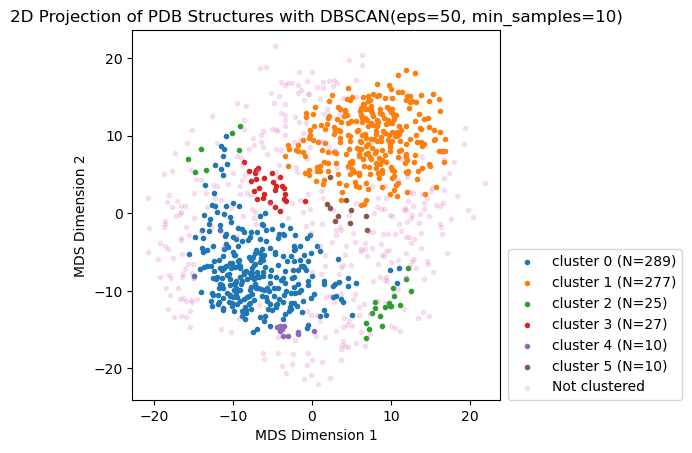

In [33]:
from sklearn.cluster import DBSCAN
eps =  50
min_samples = 10
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

plt.figure()
for c in set(clustering.labels_):
    if c == -1: 
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
    else:
        n = sum(clustering.labels_ == c)
        plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
plt.legend(loc = (1.02,0))
plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# plt.colorbar(label=label)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
plt.subplots_adjust(right=0.7)
# plt.savefig(f"{pdb_dir}/rmsd_mds_dbscan_eps{eps}.png", dpi = 300)
plt.show()


In [28]:
# min_samples = 5
# clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(rmsd)

# plt.figure()
# for c in set(clustering.labels_):
#     if c == -1: 
#         plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label="Not clustered", marker=".", alpha=0.2)
#     else:
#         n = sum(clustering.labels_ == c)
#         plt.scatter(coords[clustering.labels_ == c, 0], coords[clustering.labels_ == c, 1], label=f"cluster {c} (N={n})", marker=".")
# plt.legend(loc = (1.02,0))
# plt.xlim(min(coords[:, 0])-2, max(coords[:, 0])+2)
# plt.ylim(min(coords[:, 1])-2, max(coords[:, 1])+2)

# # plt.colorbar(label=label)
# plt.xlabel('MDS Dimension 1')
# plt.ylabel('MDS Dimension 2')
# plt.title(f'2D Projection of PDB Structures with DBSCAN(eps={eps}, min_samples={min_samples})')
# plt.subplots_adjust(right=0.7)
# # plt.savefig(f"{pdb_dir}/rmsd_mds_dbscan_eps{eps}.png", dpi = 300)
# plt.show()


In [29]:
df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores.csv")
df_scores["cluster"] = clustering.labels_
df_scores.to_csv(f"{pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv", index=False)
df_scores = pd.read_csv(f"{pdb_dir}/{casp_id}_scores_clustered_eps{eps}.csv")
df_scores.head(3)

,pdb,BRiQscore,FARFARscore,cluster
0,S_000001,-198.758,129.924,-1
1,S_000002,-113.573,-124.681,0
2,S_000003,-161.397,-118.070,-1


In [34]:
pdb_list = []

# for cluster in set(clustering.labels_):
for cluster in [0,1]:
    if cluster == -1: continue
    print(f"Cluster {cluster}")
    print(" Sorted by BRiQscore")
    print(df_scores[df_scores["cluster"] == cluster].sort_values("BRiQscore").head(5))
    print(" Sorted by FARFARscore")
    print(df_scores[df_scores["cluster"] == cluster].sort_values("FARFARscore").head(5))
    pdb_list.extend(df_scores[df_scores["cluster"] == cluster].sort_values("BRiQscore").head(5)["pdb"].values)
    print("**"*20)
# print(" Sorted by BRiQscore")
# print(df_scores.sort_values("BRiQscore").head(10))
# pdb_list.extend(df_scores.sort_values("BRiQscore").head(5)["pdb"].values)
# print(" Sorted by FARFARscore")
# print(df_scores.sort_values("FARFARscore").head(10))
# pdb_list.extend(df_scores.sort_values("FARFARscore").head(5)["pdb"].values)
# print("**"*20)



Cluster 0
 Sorted by BRiQscore
          pdb  BRiQscore  FARFARscore  cluster
954  S_000955   -243.488     -167.443        0
91   S_000092   -231.507     -164.518        0
337  S_000338   -227.812     -173.193        0
251  S_000252   -224.015     -164.425        0
441  S_000442   -222.933      -95.596        0
 Sorted by FARFARscore
          pdb  BRiQscore  FARFARscore  cluster
425  S_000426   -157.727     -194.674        0
257  S_000258   -146.428     -186.624        0
593  S_000594   -185.538     -185.845        0
74   S_000075   -199.828     -182.861        0
279  S_000280   -172.466     -182.810        0
****************************************
Cluster 1
 Sorted by BRiQscore
          pdb  BRiQscore  FARFARscore  cluster
811  S_000812   -250.477      -40.871        1
614  S_000615   -244.473     -163.837        1
209  S_000210   -234.189     -130.801        1
146  S_000147   -230.475     -174.412        1
355  S_000356   -230.152     -164.506        1
 Sorted by FARFARscore
     

In [35]:

df_rmsd[pdb_list].loc[pdb_list].to_csv(f"{pdb_dir}/rmsd_matrix_clustered_top5s.csv")